# Support Vector Machines

- classification, regression and outlier-detection
- well suited for classification of complex, small- or medium-sized datasets

## Linear SVM Classification

- `iris` dataset: *linearly separable*
 - There can be multiple decision boundaries possible. If the boundary is too close to the individual instances then there is a risk that the model not perform well on new data.
 - SVM decision boundaries using **large margin classification** fits the widest possible street (not just a line, but area between two parallels) between the datasets. This decision boundary will perform well on new data (more likely to)

- Moral: SVM fits a *street*
  - Adding more training instances "off the *street*" will not affect the decision boundary
  - The *street* is supported by instances at its edge, called *support vectors* (circled in red, right of Fig 5.1)


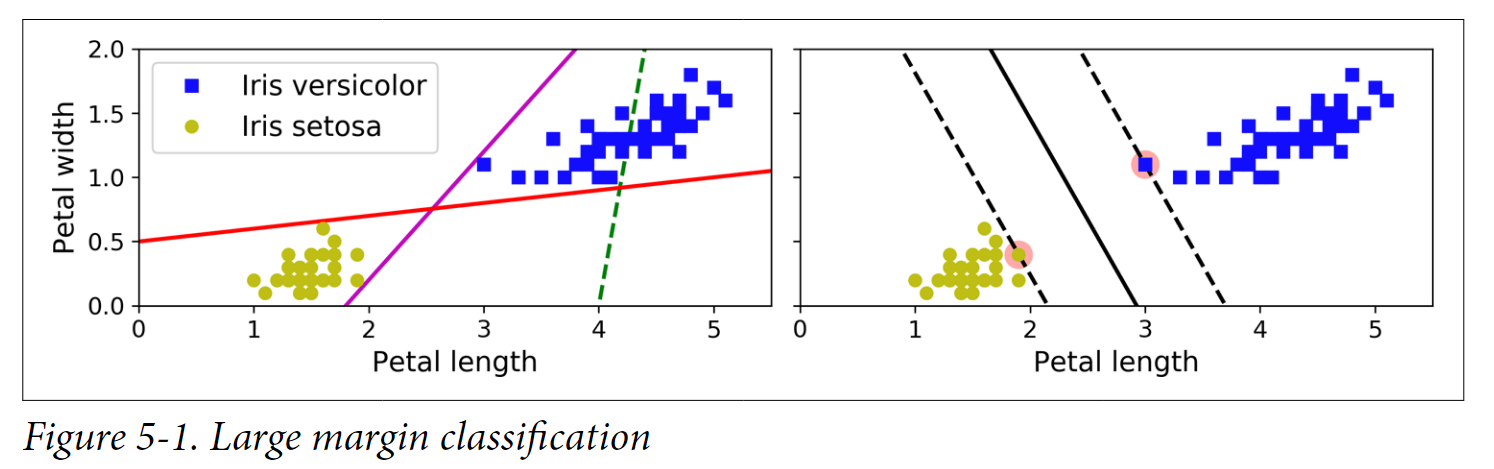

- SVM is sensitive to feature scale. Can change the *support vectors* supporting the decision boundary *street*

### Soft Margin Classification

- All instances *must* be off-the-street and on the right ⇒ **hard margin classification**.
 - Only works if linearly separable
 - Outliers will make it impossible to work

- Thus use a more flexible model. Balance:
 - Street, as large as possible \[ Generalize better \]
 - limiting the *margin violations* (wrong side/middle of street) \[  \]

- `C` hyperparameter: Higher is more rigid (narrower) ⇒ Lesser violations (But overfitting!)
 - Reduce to regularize.
 - Think of `C` as "the amount of strength to push the instances out of the *street*"

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2,3)] # petal length, petal width
y = (iris['target'] == 2).astype(np.float)

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])
svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [ ]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

- `LinearSVC` is effectively:
 - use `SVC` with *linear kernel* `SVC(kernel="linear", C=1)`
 - `SGDClassifier(loss="hinge", alpha=1/(m*C))`
  - Useful for online classification tasks
  - Huge datasets (out-of-core learning)

- `LinearSVC` regularizes bias term so first centre the training set (subtract the mean)... done by `StandardScaler`

## Nonlienar SVM Classification

- Features with nonlinear patterns is the problem that we need to resolve in this section.

- With limited features, a dataset may not be linearly separable. Add polynomial features: “Figure 5-5. Adding features to make a dataset linearly separable” ([Géron, p. 157](zotero://select/library/items/DKQ8XXHR)) ([pdf](zotero://open-pdf/library/items/5XPMGMEE?page=187&annotation=XHPFYARI))

- Moral
 - Add polynomial features (to make linearly separable)
 - Scale (else regularizes bias term)

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scalar', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

polynomial_svm_clf.fit(X,y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scalar', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

### Polynomial Kernel

- Problem with adding poly features:
 - Complex datasets: low degree poly won't work
 - High degree poly: Huge number of features (combinatorial explosion) so too slow model

- Use math: *Kernel Trick* (same result as adding very high degree polynomials, without actually doing so)
 - Implemented by `SVC` class

In [ ]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
    # degree 3 => 2^3 + 1 = 8 + 1 = 9 features
])
poly_kernel_svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

- Overfitting ⇒ Reduce degree (and vice-versa)
- Use grid search to find the right parameters (coarse to get to the ball park and then finer)

### Similarity Features

- *similarity function* measures how much each instance resembles a particular *landmark*

- e.g. Gaussian RBF: $\phi_\gamma(x,\ell)$
 - =0 if very far from the landmark
 - =1 if at the landmark
 - Gaussian bell shaped with means at the *landmarks*

- Instead of plotting the original features, **plot the similarities** of the features with respect to the two landmarks in both the axes. This separates them out with a better chance of being *linearly separable*.

- How to select landmarks?
 - Simplest approach: landmark at location of each and every instance
 - Downside: Large training set ⇒ Large # of features

### Gaussian RBF Kernel

- The kernel trick for **similarity features**
- Increasing $\gamma$ makes the bell-shaped curve narrower (smaller influence per instance). Irregular boundaries, wiggling around individual instances.
 - Think of $\gamma$ as a gravitational field around each instance pulling the decision boundary.
 - A regularization parameter: Reduce when model overfitting.


In [ ]:
rbf_kernel_svm_clf = Pipeline([
    ('scalar', StandardScaler()),
    ('svm_clf', SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X,y)

Pipeline(steps=[('scalar', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

There are many more kernels (used for specific purposes and thus rarer than these.

- *String kernels* classify text documents or DNA sequences. E.g. *string subsequence kernel*

- Use *Linear kernel* first (`LinearSVC` is faster than `SVC(kernel="linear")`
- If training set not too large, also use Gaussian RBF kernel (generally works well)
- If no time constraint, experiment with other kernels (use cross-validation) and grid search.
- Again, its a good idea to visualize the data to see what's happening.

### Computational Complexity

- `LinearSVC` is $O(m\times n)$ good for large training sets.
- `SVC` (supports "Kernel trick") good for small-medium training sets. Scales well with \# of (especially *sparse*) features


| Class           | Time Complexity                 | Out-of-core support? | Need Scaling? | Kernel Trick? |
| --------------- | ------------------------------- | -------------------- | ------------- | ------------- |
| `LinearSVC`     | $O(m\times n)$                  | No                   | Yes           | No            |
| `SGDClassifier` | $O(m\times n)$                  | Yes                  | Yes           | No            |
| `SVC`           | $O(m^2\times n)-O(m^3\times n)$ | No                   | Yes           | Yes           |


## SVM Regression

- Supports linear and non-linear regression too!
- Reverse for regression: Try to fit as many instances *on* the street while limiting margin violations (*off* the street)
- Width of the street: $\epsilon$. Model is $\epsilon$-*insensitive* (adding more in the margin doesn't affect predictions)

In [ ]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X,y)

LinearSVR(epsilon=1.5)

- To tackle nonlinear regression (use *kernelized* SVM)
- Increase in `C`, causes a very slight regularization.

In [ ]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X,y)

SVR(C=100, degree=2, kernel='poly')

- Just like `LinearSVC`, the `LinearSVR` scales linearly with the size ofthe training set, while `SVR` gets slow with large training sets.

## Under the hood

> Will do it in the 2nd_Pass

### Decision Function and Predictions

### Training Objective

### Quadratic Programming

### The Dual Problem

### Kernelized SVMs

### Online SVMs